In [1]:
%matplotlib inline
import sys
sys.path.append('..')
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from IPython.display import clear_output
import time
from modules.factory import ohlc_chart
from modules.tfmodels import CNN

### 1. 데이터 불러오기

In [2]:
#training_file = '../data/trend-60day-localstd.csv'
#xy = np.genfromtxt(training_file, delimiter=',', dtype=np.float32)
xy1 = np.genfromtxt('../data/120day_trend(normed_by_globalstd)_2.csv', delimiter=',', dtype=np.float32)
xy2 = np.genfromtxt('../data/120day_trend(normed_by_globalstd)_1.csv', delimiter=',', dtype=np.float32)
xy = np.concatenate((xy1,xy2))

##### Data Reconstruction

In [3]:
test_len = 100
length = xy.shape[0]

# data reconstruction
X_Data = np.stack( (xy[0::4, :-1], xy[1::4, :-1], xy[2::4, :-1], xy[3::4, :-1]), axis=-1)
# y 데이터 구조 변경: 0~2 --> [1,0,0], [0,1,0], [0,0,1]
y = xy[::4, -1].astype(np.int16)
Y_Data = np.zeros((y.size, y.max().astype(np.int32)+1))
Y_Data[np.arange(y.size), y] = 1

#train data
X_Train = X_Data[test_len:]
Y_Train = Y_Data[test_len:]
X_Test = X_Data[:test_len]
Y_Test = Y_Data[:test_len]

In [4]:
# initialize
sess = tf.Session()

In [5]:
period = 120
cnn = CNN(sess, "trend", period=period)
#filepath = f'../tf/{period}_trend_weight.ckpt'

In [11]:
saver = tf.train.Saver()

In [7]:
filepath = '../data/tf/120day_trend_weight.ckpt'
#saver.restore(sess, filepath)
sess.run(tf.global_variables_initializer())

In [8]:
timer = time.time()
for step in range(500):
    c, _ = cnn.train(X_Train, Y_Train)
    if step % 100 == 0:
        timediff = time.time() - timer
        timer = time.time()
        print('step: ', step, 'cost: ', c , ' (%.2f sec)'%timediff)
print('Done')

step:  0 cost:  1.08606  (5.29 sec)
step:  100 cost:  0.0866643  (754.18 sec)
step:  200 cost:  0.0159315  (821.25 sec)
step:  300 cost:  0.00945595  (830.80 sec)
step:  400 cost:  0.00313911  (704.79 sec)
Done


In [9]:
print('Accuracy:', cnn.get_accuracy(X_Test, Y_Test))

Accuracy: 0.84


In [12]:
save_path = saver.save(sess, filepath)
print("Model saved in file: %s" % save_path)

Model saved in file: ../data/tf/120day_trend_weight.ckpt


### 2. 테스트

##### 1) 테스트 데이터

real:  0
pred: 0
[[ 11.18683338   2.13602638 -14.48971748]]


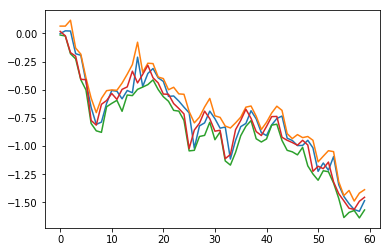

In [57]:
for num in range(10):
    #num = np.random.randint(0,len(test_X))
    data = X_Test[num]
    real = np.argmax(Y_Test[num])
    pred = m1.predict([X_Test[num]])
    
    print('real: ', real)
    print('pred:', np.argmax(pred))
    print(pred)
    plt.plot(data)
    plt.show()
    input()
    clear_output(wait=True)

##### 2) 실 데이터

In [12]:
#실 데이터 테스트
import quandl
import pandas as pd
quandl.ApiConfig.api_key = "UzB-e5CDdoACq4ENxbVS"
df = pd.read_csv('../data/SCF-meta.csv')
df['iid'] = 'SCF/'+df.Exchange+'_'+df.Symbol+'1_OB'
meta = df[['iid','name']]

EUREX Euro-Schatz
mean: -0.99


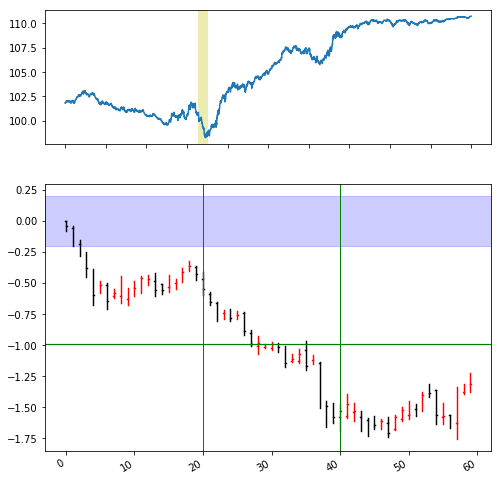

pred: 0
[[  8.20800018   2.01999998 -11.24300003]]
prob:  [[ 0.99800003  0.002       0.        ]]
q


In [17]:
window = 60
while True:
    idx = np.random.randint(0, len(meta))
    code = meta.iloc[idx].iid
    name = meta.iloc[idx]['name']

    raw_data = quandl.get(code)
    raw_data.drop(['Volume', 'Prev. Day Open Interest'], axis=1, inplace=True)
    std = raw_data.Settle.std()
    length = len(raw_data)
    
    for i in range(10):
        print(name)
        
        start = np.random.randint(0, length -  window)
        end = start + window
        
        if start-240 < 0:
            start0 = 0
            end0 = 540
        elif end+240 > len(raw_data):
            end0 = len(raw_data)
            start0 = end0-540
        else:
            start0 = start-240
            end0 = end+240
            
        #Data Normalization
        std = raw_data.Settle.values[start0:end0].std()
        data = raw_data[start:end]
        data = (data-data.iloc[0].Open)/std
        
        #그래프 
        fig, (ax) = plt.subplots(2,1, gridspec_kw = {'height_ratios':[1, 2]}, figsize=(8,9))
        fig.autofmt_xdate()
            
        ax[0].plot(raw_data.index.values, raw_data.Settle.values)
        ax[0].axvspan(raw_data.index.values[start], raw_data.index.values[end], facecolor='y', alpha=0.3)
        
        ohlc_data = np.concatenate((np.arange(len(data)).reshape(-1, 1), data.values), axis=1)
        ohlc_chart(ax[1], ohlc_data, linewidth=1.44)
        mean = data.values.mean()
        print('mean: %.2f'%mean)
        ax[1].axhline(y=mean, linewidth=1.2, color='g')
        ax[1].axhspan(-0.2, 0.2, color='b', alpha=0.2)
        ax[1].axvline(x=int(len(data)/3), linewidth=1, color='g')
        ax[1].axvline(x=int(len(data)*2/3), linewidth=1, color='g')
        plt.show()
        
        #추세
        time.sleep(0.1)
        
        temp = data.values.T
        test_data = np.stack( (temp[0::4, :], temp[1::4, :], temp[2::4, :], temp[3::4, :]), axis=-1)
        pred = m1.predict(test_data)
    
        print('pred:', np.argmax(pred))
        print(np.round(pred,3))
        print('prob: ', np.round(sess.run(tf.nn.softmax(pred)),3))
        key = input()
        
        clear_output(wait=True)
        if key == 'q':
            break
    if key == 'q':
            break
    clear_output(wait=True)

In [39]:
sess.run(tf.nn.softmax(pred))

array([[  6.31562500e-08,   9.99999881e-01,   3.38847349e-21]], dtype=float32)